In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
PATH = f'../data/connectomes/'
DATASET = ''

selected_networks = [
    'c.elegans_neural.male_1.graphml',
    'mouse_brain_1.graphml',
    'mouse_visual.cortex_2.graphml', 
    'p.pacificus_neural.synaptic_2.graphml',
    'rhesus_brain_2.graphml'
]

# Read graphs for selected networks
graphs = []
for network in selected_networks:
    try:
        g = nx.read_graphml(PATH + network)
        graphs.append(g)
    except Exception as e:
        print(f"Error reading {network}: {e}")

# Sort networks and graphs by size
if len(graphs) > 0:
    graph_sizes = [(f, len(g.nodes())) for f, g in zip(selected_networks, graphs)]
    graph_sizes.sort(key=lambda x: x[1])
    selected_networks = [f for f, _ in graph_sizes]
    graphs = [g for _, g in sorted(zip(graph_sizes, graphs), key=lambda x: x[0][1])]


In [5]:
# Load the results
df_results = pd.read_csv('tabela_caracteristicas.csv')
df_results.head(10)

,Unnamed: 0,network,estimated_sigma,adjusted_hops,vertices,edges,degree_centrality,betweenness_centrality,closeness_centrality,clustering_coeff,density,transitivity,average_Degree,maximum_Degree
0,0,rhesus_brain_2,-5.395738,0,91,294,0.071795,0.016403,0.384434,0.162076,0.071795,0.130680,6.461538,27
1,0,rattus.norvegicus_brain_1,-1.648310,2,503,9172,0.072648,0.001982,0.502056,0.071255,0.072648,0.071328,36.469185,54
2,0,p.pacificus_neural.synaptic_1,-3.125950,0,54,427,0.298393,0.013587,0.587213,0.308822,0.298393,0.301250,15.814815,25
3,0,rhesus_brain_1,-6.183950,2,242,1923,0.065944,0.005250,0.443717,0.062656,0.065944,0.062410,15.892562,27
4,0,rattus.norvegicus_brain_3,-3.870713,1,496,8398,0.068410,0.002071,0.494658,0.068315,0.068410,0.068104,33.862903,56
5,0,rattus.norvegicus_brain_2,-3.019719,2,503,8822,0.069876,0.002015,0.497879,0.069074,0.069876,0.068925,35.077535,52
6,0,p.pacificus_neural.synaptic_2,-2.921838,0,50,520,0.424490,0.011990,0.636553,0.447899,0.424490,0.441990,20.800000,29
7,0,mouse_brain_1,-1.755647,1,213,7984,0.353619,0.003063,0.607674,0.355194,0.353619,0.355112,74.967136,95
8,0,c.elegans.herm_pharynx_1,-4.338917,2,279,3555,0.091669,0.003599,0.501156,0.090847,0.091669,0.091318,25.483871,38
9,0,mouse_visual.cortex_2,-6.098704,1,195,266,0.014063,0.010448,0.175089,0.016090,0.014063,0.027248,2.728205,13


In [6]:
def get_logit_graph(real_graph, d, n_iteration, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.

   Args:
       real_graph (nx.Graph or np.ndarray): The target graph.
       d (int): Parameter for the Logit model (number of neighbors).
       n_iteration (int): Maximum number of iterations for graph generation.
       warm_up (int): Number of initial iterations to discard.
       patience (int): Number of iterations to wait for improvement before stopping.
       dist_type (str): Distance type for GIC ('KL', 'L1', 'L2').
       convergence_criteria (str): Criterion for stopping ('spectrum' or 'spectrum_and_edges').

   Returns:
       tuple: Contains the best generated graph, sigma, GIC values,
              spectrum differences, edge differences, best iteration index, and all graphs.
   """
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   # Using default L1 regularization as before, adjust if needed
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "patience": patience,
      "edge_delta": edge_delta,
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation with convergence criterion: {edge_delta}")
   
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )


   print(f"Finish generation with convergence criterion: {edge_delta}")
   # Calculate edge differences
   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   # Use the best graph found based on the selected criteria/iteration
   # best_graph = graphs[best_iteration]

   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs


In [7]:
# Updated fit_logit_graphs_to_dataset function to properly return sigma and d values
def fit_logit_graphs_to_dataset_improved(graphs, n_graphs=5, sim_params=None):
    """
    Fit logit graph models to the selected graphs and extract network features.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
        
    Returns:
    --------
    results : list
        List of dictionaries containing results for each network
    """
    results = []
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        # Test different d values and find the best one based on GIC
        best_gic_value = float('inf')
        best_d = 0
        best_sigma = None
        best_fitted_graph = None
        
        for d in range(sim_params["d_range"]): 
            print(f"\n{'='*20} Processing Graph {i+1}/{n_graphs} with d={d} {'='*20}")
            try:
                logit_results = get_logit_graph(
                    real_graph=adj_matrix.copy(),
                    d=d,
                    n_iteration=sim_params["n_iteration"],
                    patience=sim_params["patience"],
                    dist_type=sim_params["dist_type"],
                    edge_delta=sim_params["edge_delta"],
                    min_gic_threshold=sim_params["min_gic_threshold"],
                    verbose=sim_params["verbose"],
                )
                
                fitted_adj_matrix, sigma, gic_values, spectrum_diffs, edge_diffs, best_iteration, all_graphs = logit_results
                gic_value = gic_values[0]
                
                print(f"  d={d}: sigma={sigma:.4f}, GIC={gic_value:.4f}")
                
                if gic_value < best_gic_value:
                    best_gic_value = gic_value
                    best_d = d
                    best_sigma = sigma
                    best_fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
                    
            except Exception as e:
                print(f"  Error with d={d}: {str(e)}")
                continue
        
        if best_fitted_graph is None:
            print(f"Failed to fit any model for graph {i+1}")
            continue
            
        result = {
            'network': graphs[i],
            'sigma': best_sigma,
            'd_parameter': best_d,
            'n_vertices': n_nodes,
            'n_edges': n_edges,
            'gic_value': best_gic_value,
            'fitted_graph': best_fitted_graph,
        }
        
        results.append(result)
        
    return results


In [8]:
# Match selected networks with df_results and extract parameters
def get_network_params_from_results(selected_networks, df_results):
    """
    Match selected networks with df_results and extract sigma and d parameters
    """
    network_params = {}
    
    for network_file in selected_networks:
        # Remove .graphml extension and try to match with df_results
        network_name = network_file.replace('.graphml', '')
        
        # Try exact match first
        matches = df_results[df_results['network'] == network_name]
        
        # If no exact match, try partial matching
        if matches.empty:
            matches = df_results[df_results['network'].str.contains(network_name.split('_')[0], na=False)]
        
        # If still no match, try more flexible matching
        if matches.empty:
            for _, row in df_results.iterrows():
                if any(part in row['network'] for part in network_name.split('_')[:2]):
                    matches = df_results[df_results['network'] == row['network']]
                    break
        
        if not matches.empty:
            # Take the first match if multiple
            match = matches.iloc[0]
            network_params[network_file] = {
                'sigma': match['estimated_sigma'],
                'd': match['adjusted_hops'],
                'matched_name': match['network']
            }
            print(f"Matched {network_file} -> {match['network']}")
            print(f"  sigma: {match['estimated_sigma']:.4f}, d: {match['adjusted_hops']}")
        else:
            print(f"No match found for {network_file}")
    
    return network_params

# Get parameters for selected networks
network_params = get_network_params_from_results(selected_networks, df_results)
print(f"\nFound parameters for {len(network_params)} networks")


Matched p.pacificus_neural.synaptic_2.graphml -> p.pacificus_neural.synaptic_2
  sigma: -2.9218, d: 0
Matched rhesus_brain_2.graphml -> rhesus_brain_2
  sigma: -5.3957, d: 0
Matched mouse_visual.cortex_2.graphml -> mouse_visual.cortex_2
  sigma: -6.0987, d: 1
Matched mouse_brain_1.graphml -> mouse_brain_1
  sigma: -1.7556, d: 1
Matched c.elegans_neural.male_1.graphml -> c.elegans_neural.male_1
  sigma: -4.5287, d: 0

Found parameters for 5 networks


### make the simulation

In [13]:
# Generate LG graphs using specific sigma and d values
def generate_lg_graphs_with_params(graphs, selected_networks, network_params, sim_params):
    """
    Generate logit graphs using specific sigma and d parameters from df_results
    """
    results = []
    
    for i, (graph, network_file) in enumerate(zip(graphs, selected_networks)):
        if network_file not in network_params:
            print(f"Skipping {network_file} - no parameters found")
            continue
            
        params = network_params[network_file]
        sigma = params['sigma']
        d = params['d']
        
        print(f"\n{'='*50}")
        print(f"Processing {network_file}")
        print(f"Using sigma={sigma:.4f}, d={d}")
        print(f"Original graph - Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")
        
        try:
            adj_matrix = nx.to_numpy_array(graph)
            
            # Generate LG graph with specific parameters
            logit_results = get_logit_graph(
                real_graph=adj_matrix.copy(),
                d=d,
                n_iteration=sim_params["n_iteration"],
                patience=sim_params["patience"],
                dist_type=sim_params["dist_type"],
                edge_delta=sim_params["edge_delta"],
                min_gic_threshold=sim_params["min_gic_threshold"],
                verbose=sim_params["verbose"],
            )
            
            fitted_adj_matrix, fitted_sigma, gic_values, spectrum_diffs, edge_diffs, best_iteration, all_graphs = logit_results
            fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
            
            result = {
                'network_file': network_file,
                'matched_name': params['matched_name'],
                'original_graph': graph,
                'fitted_graph': fitted_graph,
                'target_sigma': sigma,
                'fitted_sigma': fitted_sigma,
                'target_d': d,
                'gic_value': gic_values[0],
                'best_iteration': best_iteration
            }
            
            results.append(result)
            
            print(f"Success! Generated graph with {fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges")
            print(f"Target sigma: {sigma:.4f}, Fitted sigma: {fitted_sigma:.4f}")
            print(f"GIC: {gic_values[0]:.4f}, Best iteration: {best_iteration}")
            
        except Exception as e:
            print(f"Error processing {network_file}: {str(e)}")
            continue
    
    return results
# # Set up simulation parameters (reduced for faster execution)
# sim_params = {
#     "n_iteration": 100,  # Reduced for faster execution
#     "patience": 5,
#     "edge_delta": 50,
#     "dist_type": 'KL',
#     "min_gic_threshold": 2,
#     "verbose": True,
# }

# original
sim_params = {
    "n_iteration": 20_000,
    "d_range": 3,
    "patience": 1000,
    "edge_delta": 50,
    "dist_type": 'KL',
    "min_gic_threshold": 2,
    "verbose": True,
}

# Generate LG graphs
print("Starting LG graph generation...")
lg_results = generate_lg_graphs_with_params(graphs, selected_networks, network_params, sim_params)


Starting LG graph generation...

Processing p.pacificus_neural.synaptic_2.graphml
Using sigma=-2.9218, d=0
Original graph - Nodes: 272, Edges: 4451
Running generation with convergence criterion: 50


Optimizing Graph:   0%|          | 3/20000 [00:00<09:13, 36.14it/s, GIC=23.0151, Spectrum Diff=446.5356, Patience=0/1000, Edges=0.0/1981.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 2)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1981.0)


Optimizing Graph:   5%|▌         | 1009/20000 [00:23<09:14, 34.26it/s, GIC=3.3563, Spectrum Diff=440.8201, Patience=0/1000, Edges=20.0/1981.0]

iteration: 1000
	 Current GIC (KL): 3.3563 (Threshold: 2)
	 Best Spectrum Diff: 440.8201
	 Patience: 0/1000
	 Current edges: 20.0 (Real edges: 1981.0)


Optimizing Graph:   9%|▉         | 1828/20000 [00:41<03:58, 76.30it/s, GIC=1.8855, Spectrum Diff=431.1032, Patience=5/1000, Edges=60.0/1981.0] 


*** GIC threshold 2 reached at iteration 1799 (GIC: 1.8855) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  10%|█         | 2026/20000 [00:42<02:08, 139.66it/s, GIC=1.8855, Spectrum Diff=426.8377, Patience=9/1000, Edges=80.0/1981.0] 

iteration: 2000
	 Best Spectrum Diff: 427.2739
	 Patience: 3/1000
	 Current edges: 78.0 (Real edges: 1981.0)


Optimizing Graph:  15%|█▌        | 3029/20000 [00:50<01:59, 141.94it/s, GIC=1.8855, Spectrum Diff=402.2114, Patience=2/1000, Edges=208.0/1981.0] 

iteration: 3000
	 Best Spectrum Diff: 403.3074
	 Patience: 4/1000
	 Current edges: 201.0 (Real edges: 1981.0)


Optimizing Graph:  20%|██        | 4021/20000 [00:58<02:27, 108.40it/s, GIC=1.8855, Spectrum Diff=321.9385, Patience=0/1000, Edges=758.0/1981.0] 

iteration: 4000
	 Best Spectrum Diff: 324.4470
	 Patience: 0/1000
	 Current edges: 741.0 (Real edges: 1981.0)


Optimizing Graph:  25%|██▌       | 5010/20000 [01:08<03:24, 73.39it/s, GIC=1.8855, Spectrum Diff=225.8192, Patience=0/1000, Edges=1674.0/1981.0] 

iteration: 5000
	 Best Spectrum Diff: 227.0440
	 Patience: 0/1000
	 Current edges: 1666.0 (Real edges: 1981.0)


Optimizing Graph:  27%|██▋       | 5384/20000 [01:13<03:19, 73.38it/s, GIC=1.8855, Spectrum Diff=194.7726, Patience=0/1000, Edges=2031.0/1981.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (50).

--- Results ---
- Best iteration found: 5383
- Best spectrum difference: 194.7726
- Edges in best graph: 2032.0 (Real graph edges: 1981.0)
Finish generation with convergence criterion: 50


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Success! Generated graph with 272 nodes, 2032 edges
Target sigma: -2.9218, Fitted sigma: -4.5287
GIC: 0.5297, Best iteration: 5383

Processing rhesus_brain_2.graphml
Using sigma=-5.3957, d=0
Original graph - Nodes: 213, Edges: 21807
Running generation with convergence criterion: 50


Optimizing Graph:   0%|          | 2/20000 [00:00<05:24, 61.55it/s, GIC=23.8003, Spectrum Diff=2242.5731, Patience=0/1000, Edges=0.0/10718.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 2)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 10718.0)


Optimizing Graph:   2%|▏         | 344/20000 [00:09<03:42, 88.38it/s, GIC=1.9487, Spectrum Diff=2228.6514, Patience=2/1000, Edges=84.0/10718.0] 


*** GIC threshold 2 reached at iteration 301 (GIC: 1.9487) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:   5%|▌         | 1031/20000 [00:13<02:09, 146.54it/s, GIC=1.9487, Spectrum Diff=2153.1156, Patience=0/1000, Edges=597.0/10718.0]

iteration: 1000
	 Best Spectrum Diff: 2157.3499
	 Patience: 1/1000
	 Current edges: 568.0 (Real edges: 10718.0)


Optimizing Graph:  10%|█         | 2024/20000 [00:21<02:45, 108.91it/s, GIC=1.9487, Spectrum Diff=2020.0889, Patience=0/1000, Edges=1549.0/10718.0]

iteration: 2000
	 Best Spectrum Diff: 2023.3978
	 Patience: 0/1000
	 Current edges: 1526.0 (Real edges: 10718.0)


Optimizing Graph:  15%|█▌        | 3019/20000 [00:31<03:18, 85.47it/s, GIC=1.9487, Spectrum Diff=1895.4682, Patience=0/1000, Edges=2448.0/10718.0] 

iteration: 3000
	 Best Spectrum Diff: 1897.7519
	 Patience: 1/1000
	 Current edges: 2432.0 (Real edges: 10718.0)


Optimizing Graph:  20%|██        | 4016/20000 [00:44<03:45, 70.76it/s, GIC=1.9487, Spectrum Diff=1776.6350, Patience=0/1000, Edges=3314.0/10718.0]

iteration: 4000
	 Best Spectrum Diff: 1778.5293
	 Patience: 0/1000
	 Current edges: 3301.0 (Real edges: 10718.0)


Optimizing Graph:  25%|██▌       | 5012/20000 [01:00<04:02, 61.70it/s, GIC=1.9487, Spectrum Diff=1659.8360, Patience=0/1000, Edges=4164.0/10718.0]

iteration: 5000
	 Best Spectrum Diff: 1661.1564
	 Patience: 0/1000
	 Current edges: 4155.0 (Real edges: 10718.0)


Optimizing Graph:  30%|███       | 6008/20000 [01:16<03:40, 63.43it/s, GIC=1.9487, Spectrum Diff=1550.2219, Patience=0/1000, Edges=4962.0/10718.0]

iteration: 6000
	 Best Spectrum Diff: 1551.2899
	 Patience: 0/1000
	 Current edges: 4955.0 (Real edges: 10718.0)


Optimizing Graph:  35%|███▌      | 7011/20000 [01:36<04:04, 53.19it/s, GIC=1.9487, Spectrum Diff=1442.1292, Patience=0/1000, Edges=5753.0/10718.0]

iteration: 7000
	 Best Spectrum Diff: 1443.1737
	 Patience: 0/1000
	 Current edges: 5746.0 (Real edges: 10718.0)


Optimizing Graph:  40%|████      | 8011/20000 [01:58<03:54, 51.14it/s, GIC=1.9487, Spectrum Diff=1344.5619, Patience=1/1000, Edges=6467.0/10718.0]

iteration: 8000
	 Best Spectrum Diff: 1345.4100
	 Patience: 0/1000
	 Current edges: 6461.0 (Real edges: 10718.0)


Optimizing Graph:  45%|████▌     | 9005/20000 [02:21<04:45, 38.54it/s, GIC=1.9487, Spectrum Diff=1248.9865, Patience=0/1000, Edges=7163.0/10718.0]

iteration: 9000
	 Best Spectrum Diff: 1249.5173
	 Patience: 1/1000
	 Current edges: 7160.0 (Real edges: 10718.0)


Optimizing Graph:  50%|█████     | 10008/20000 [02:46<04:02, 41.26it/s, GIC=1.9487, Spectrum Diff=1158.2483, Patience=0/1000, Edges=7838.0/10718.0]

iteration: 10000
	 Best Spectrum Diff: 1159.0742
	 Patience: 0/1000
	 Current edges: 7833.0 (Real edges: 10718.0)


Optimizing Graph:  55%|█████▌    | 11008/20000 [03:13<04:06, 36.51it/s, GIC=1.9487, Spectrum Diff=1075.8597, Patience=2/1000, Edges=8446.0/10718.0]

iteration: 11000
	 Best Spectrum Diff: 1076.3558
	 Patience: 0/1000
	 Current edges: 8442.0 (Real edges: 10718.0)


Optimizing Graph:  60%|██████    | 12005/20000 [03:43<04:25, 30.13it/s, GIC=1.9487, Spectrum Diff=992.9036, Patience=0/1000, Edges=9063.0/10718.0] 

iteration: 12000
	 Best Spectrum Diff: 993.1950
	 Patience: 0/1000
	 Current edges: 9062.0 (Real edges: 10718.0)


Optimizing Graph:  65%|██████▌   | 13005/20000 [04:13<03:15, 35.70it/s, GIC=1.9487, Spectrum Diff=914.9300, Patience=1/1000, Edges=9650.0/10718.0]

iteration: 13000
	 Best Spectrum Diff: 915.3352
	 Patience: 0/1000
	 Current edges: 9647.0 (Real edges: 10718.0)


Optimizing Graph:  70%|███████   | 14007/20000 [04:46<03:03, 32.72it/s, GIC=1.9487, Spectrum Diff=840.4512, Patience=0/1000, Edges=10212.0/10718.0] 

iteration: 14000
	 Best Spectrum Diff: 840.8020
	 Patience: 0/1000
	 Current edges: 10210.0 (Real edges: 10718.0)


Optimizing Graph:  75%|███████▌  | 15004/20000 [05:19<03:06, 26.79it/s, GIC=1.9487, Spectrum Diff=769.8897, Patience=0/1000, Edges=10752.0/10718.0]

iteration: 15000
	 Best Spectrum Diff: 770.1755
	 Patience: 0/1000
	 Current edges: 10751.0 (Real edges: 10718.0)


Optimizing Graph:  75%|███████▌  | 15040/20000 [05:20<01:45, 46.91it/s, GIC=1.9487, Spectrum Diff=767.7300, Patience=0/1000, Edges=10768.0/10718.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (50).

--- Results ---
- Best iteration found: 15039
- Best spectrum difference: 767.7300
- Edges in best graph: 10769.0 (Real graph edges: 10718.0)
Finish generation with convergence criterion: 50
Success! Generated graph with 213 nodes, 10769 edges
Target sigma: -5.3957, Fitted sigma: -1.8538
GIC: 0.0860, Best iteration: 15039

Processing mouse_visual.cortex_2.graphml
Using sigma=-6.0987, d=1
Original graph - Nodes: 195, Edges: 214
Running generation with convergence criterion: 50


Optimizing Graph:   0%|          | 18/20000 [00:00<02:55, 113.73it/s, GIC=22.3849, Spectrum Diff=90.6201, Patience=0/1000, Edges=0.0/242.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 2)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 242.0)


Optimizing Graph:   5%|▌         | 1022/20000 [00:10<03:04, 102.76it/s, GIC=21.4502, Spectrum Diff=88.9265, Patience=0/1000, Edges=2.0/242.0]

iteration: 1000
	 Current GIC (KL): 21.4502 (Threshold: 2)
	 Best Spectrum Diff: 88.9265
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 242.0)


Optimizing Graph:  10%|█         | 2021/20000 [00:20<02:54, 103.09it/s, GIC=21.4183, Spectrum Diff=87.5143, Patience=0/1000, Edges=4.0/242.0]

iteration: 2000
	 Current GIC (KL): 21.4183 (Threshold: 2)
	 Best Spectrum Diff: 87.5143
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 242.0)


Optimizing Graph:  14%|█▍        | 2778/20000 [00:27<01:56, 147.68it/s, GIC=1.8206, Spectrum Diff=69.0641, Patience=1/1000, Edges=59.0/242.0] 


*** GIC threshold 2 reached at iteration 2727 (GIC: 1.8206) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  15%|█▌        | 3044/20000 [00:28<01:18, 216.64it/s, GIC=1.8206, Spectrum Diff=59.7205, Patience=3/1000, Edges=212.0/242.0] 

iteration: 3000
	 Best Spectrum Diff: 60.7547
	 Patience: 5/1000
	 Current edges: 184.0 (Real edges: 242.0)


Optimizing Graph:  16%|█▌        | 3135/20000 [00:29<02:37, 106.88it/s, GIC=1.8206, Spectrum Diff=59.7205, Patience=94/1000, Edges=292.0/242.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (50).

--- Results ---
- Best iteration found: 3040
- Best spectrum difference: 59.7205
- Edges in best graph: 210.0 (Real graph edges: 242.0)
Finish generation with convergence criterion: 50


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Success! Generated graph with 195 nodes, 210 edges
Target sigma: -6.0987, Fitted sigma: -6.0987
GIC: 1.1924, Best iteration: 3040

Processing mouse_brain_1.graphml
Using sigma=-1.7556, d=1
Original graph - Nodes: 50, Edges: 611
Running generation with convergence criterion: 50


Optimizing Graph:   0%|          | 64/20000 [00:00<01:00, 329.87it/s, GIC=10.9875, Spectrum Diff=250.2728, Patience=0/1000, Edges=9.0/529.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 2)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 529.0)


Optimizing Graph:   1%|          | 214/20000 [00:00<00:42, 467.56it/s, GIC=0.6723, Spectrum Diff=217.0940, Patience=0/1000, Edges=135.0/529.0]


*** GIC threshold 2 reached at iteration 100 (GIC: 0.6723) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:   4%|▍         | 886/20000 [00:02<00:48, 391.65it/s, GIC=0.6723, Spectrum Diff=177.7607, Patience=70/1000, Edges=579.0/529.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (50).

--- Results ---
- Best iteration found: 815
- Best spectrum difference: 177.7607
- Edges in best graph: 547.0 (Real graph edges: 529.0)
Finish generation with convergence criterion: 50
Success! Generated graph with 50 nodes, 547 edges
Target sigma: -1.7556, Fitted sigma: -3.0211
GIC: 4.9567, Best iteration: 815

Processing c.elegans_neural.male_1.graphml
Using sigma=-4.5287, d=0
Original graph - Nodes: 91, Edges: 628
Running generation with convergence criterion: 50


Optimizing Graph:   0%|          | 27/20000 [00:00<01:44, 191.44it/s, GIC=23.5666, Spectrum Diff=211.9953, Patience=0/1000, Edges=0.0/243.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 2)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 243.0)


Optimizing Graph:   5%|▌         | 1040/20000 [00:05<01:40, 189.48it/s, GIC=23.3308, Spectrum Diff=209.7943, Patience=0/1000, Edges=3.0/243.0]

iteration: 1000
	 Current GIC (KL): 23.3308 (Threshold: 2)
	 Best Spectrum Diff: 209.7943
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 243.0)


Optimizing Graph:  10%|█         | 2030/20000 [00:12<02:05, 143.52it/s, GIC=13.9362, Spectrum Diff=207.7886, Patience=0/1000, Edges=5.0/243.0]

iteration: 2000
	 Current GIC (KL): 13.9362 (Threshold: 2)
	 Best Spectrum Diff: 207.7886
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 243.0)


Optimizing Graph:  15%|█▍        | 2921/20000 [00:17<01:20, 211.74it/s, GIC=1.4164, Spectrum Diff=198.6887, Patience=79/1000, Edges=23.0/243.0]


*** GIC threshold 2 reached at iteration 2841 (GIC: 1.4164) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  15%|█▌        | 3097/20000 [00:17<00:44, 380.83it/s, GIC=1.4164, Spectrum Diff=195.9139, Patience=14/1000, Edges=31.0/243.0] 

iteration: 3000
	 Best Spectrum Diff: 198.6887
	 Patience: 158/1000
	 Current edges: 23.0 (Real edges: 243.0)


Optimizing Graph:  20%|██        | 4078/20000 [00:20<00:42, 372.77it/s, GIC=1.4164, Spectrum Diff=154.1396, Patience=0/1000, Edges=177.0/243.0]

iteration: 4000
	 Best Spectrum Diff: 161.9483
	 Patience: 0/1000
	 Current edges: 139.0 (Real edges: 243.0)


Optimizing Graph:  21%|██        | 4245/20000 [00:20<01:16, 204.68it/s, GIC=1.4164, Spectrum Diff=138.6215, Patience=0/1000, Edges=293.0/243.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (50).

--- Results ---
- Best iteration found: 4244
- Best spectrum difference: 138.6215
- Edges in best graph: 294.0 (Real graph edges: 243.0)
Finish generation with convergence criterion: 50
Success! Generated graph with 91 nodes, 294 edges
Target sigma: -4.5287, Fitted sigma: -5.3957
GIC: 0.9419, Best iteration: 4244


In [14]:
# Visualization functions for comprehensive comparison
def plot_all_graphs_comparison(lg_results, figsize=(20, 12)):
    """
    Create a comprehensive visualization showing all graphs in subplots
    """
    n_networks = len(lg_results)
    if n_networks == 0:
        print("No results to plot")
        return
    
    # Create subplot grid (2 columns: original and LG generated)
    fig, axes = plt.subplots(n_networks, 2, figsize=figsize)
    
    # Handle case where there's only one network
    if n_networks == 1:
        axes = axes.reshape(1, -1)
    
    for i, result in enumerate(lg_results):
        original_graph = result['original_graph']
        fitted_graph = result['fitted_graph']
        network_name = result['network_file'].replace('.graphml', '')
        
        # Original graph
        pos1 = nx.spring_layout(original_graph, seed=42, k=1, iterations=50)
        nx.draw_networkx(original_graph, pos=pos1, ax=axes[i, 0], 
                        node_color='lightblue', node_size=30, 
                        with_labels=False, edge_color='gray', alpha=0.7, width=0.5)
        axes[i, 0].set_title(f'{network_name} (Original)\nNodes: {original_graph.number_of_nodes()}, Edges: {original_graph.number_of_edges()}', 
                            fontsize=10)
        axes[i, 0].axis('off')
        
        # LG Generated graph
        pos2 = nx.spring_layout(fitted_graph, seed=42, k=1, iterations=50)
        nx.draw_networkx(fitted_graph, pos=pos2, ax=axes[i, 1],
                        node_color='lightcoral', node_size=30,
                        with_labels=False, edge_color='gray', alpha=0.7, width=0.5)
        axes[i, 1].set_title(f'{network_name} (LG Generated)\nNodes: {fitted_graph.number_of_nodes()}, Edges: {fitted_graph.number_of_edges()}\nσ={result["fitted_sigma"]:.3f}, d={result["target_d"]}, GIC={result["gic_value"]:.3f}', 
                            fontsize=10)
        axes[i, 1].axis('off')
    
    plt.suptitle('Graph Structure Comparison: Original vs LG Generated', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_all_degree_distributions_comparison(lg_results, figsize=(20, 12)):
    """
    Create a comprehensive visualization showing all degree distributions in subplots
    """
    n_networks = len(lg_results)
    if n_networks == 0:
        print("No results to plot")
        return
    
    # Create subplot grid (2 columns: original and LG generated)
    fig, axes = plt.subplots(n_networks, 2, figsize=figsize)
    
    # Handle case where there's only one network
    if n_networks == 1:
        axes = axes.reshape(1, -1)
    
    for i, result in enumerate(lg_results):
        original_graph = result['original_graph']
        fitted_graph = result['fitted_graph']
        network_name = result['network_file'].replace('.graphml', '')
        
        # Original graph degree distribution
        degrees_orig = [d for n, d in original_graph.degree()]
        max_degree_orig = max(degrees_orig) if degrees_orig else 1
        bins_orig = min(20, max_degree_orig + 1)
        
        axes[i, 0].hist(degrees_orig, bins=bins_orig, alpha=0.7, color='lightblue', edgecolor='black')
        axes[i, 0].set_title(f'{network_name} (Original)\nDegree Distribution', fontsize=10)
        axes[i, 0].set_xlabel('Degree', fontsize=9)
        axes[i, 0].set_ylabel('Frequency', fontsize=9)
        axes[i, 0].tick_params(axis='both', which='major', labelsize=8)
        
        # LG Generated graph degree distribution
        degrees_fitted = [d for n, d in fitted_graph.degree()]
        max_degree_fitted = max(degrees_fitted) if degrees_fitted else 1
        bins_fitted = min(20, max_degree_fitted + 1)
        
        axes[i, 1].hist(degrees_fitted, bins=bins_fitted, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[i, 1].set_title(f'{network_name} (LG Generated)\nDegree Distribution', fontsize=10)
        axes[i, 1].set_xlabel('Degree', fontsize=9)
        axes[i, 1].set_ylabel('Frequency', fontsize=9)
        axes[i, 1].tick_params(axis='both', which='major', labelsize=8)
    
    plt.suptitle('Degree Distribution Comparison: Original vs LG Generated', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_graph_metrics_comparison(lg_results):
    """
    Create a comparison table of graph metrics
    """
    metrics_data = []
    
    for result in lg_results:
        orig_graph = result['original_graph']
        fitted_graph = result['fitted_graph']
        
        # Calculate metrics
        orig_metrics = {
            'nodes': orig_graph.number_of_nodes(),
            'edges': orig_graph.number_of_edges(),
            'density': nx.density(orig_graph),
            'avg_degree': sum(dict(orig_graph.degree()).values()) / orig_graph.number_of_nodes()
        }
        
        fitted_metrics = {
            'nodes': fitted_graph.number_of_nodes(),
            'edges': fitted_graph.number_of_edges(),
            'density': nx.density(fitted_graph),
            'avg_degree': sum(dict(fitted_graph.degree()).values()) / fitted_graph.number_of_nodes()
        }
        
        metrics_data.append({
            'Network': result['network_file'].replace('.graphml', ''),
            'Type': 'Original',
            **orig_metrics
        })
        
        metrics_data.append({
            'Network': result['network_file'].replace('.graphml', ''),
            'Type': 'LG Generated',
            **fitted_metrics
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    metrics_to_plot = ['edges', 'density', 'avg_degree']
    
    for i, metric in enumerate(metrics_to_plot):
        if i < len(axes):
            pivot_df = df_metrics.pivot(index='Network', columns='Type', values=metric)
            pivot_df.plot(kind='bar', ax=axes[i], alpha=0.8)
            axes[i].set_title(f'{metric.replace("_", " ").title()}')
            axes[i].set_xlabel('Network')
            axes[i].set_ylabel(metric.replace("_", " ").title())
            axes[i].legend()
            axes[i].tick_params(axis='x', rotation=45)
    
    # Remove empty subplot
    if len(metrics_to_plot) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    return df_metrics


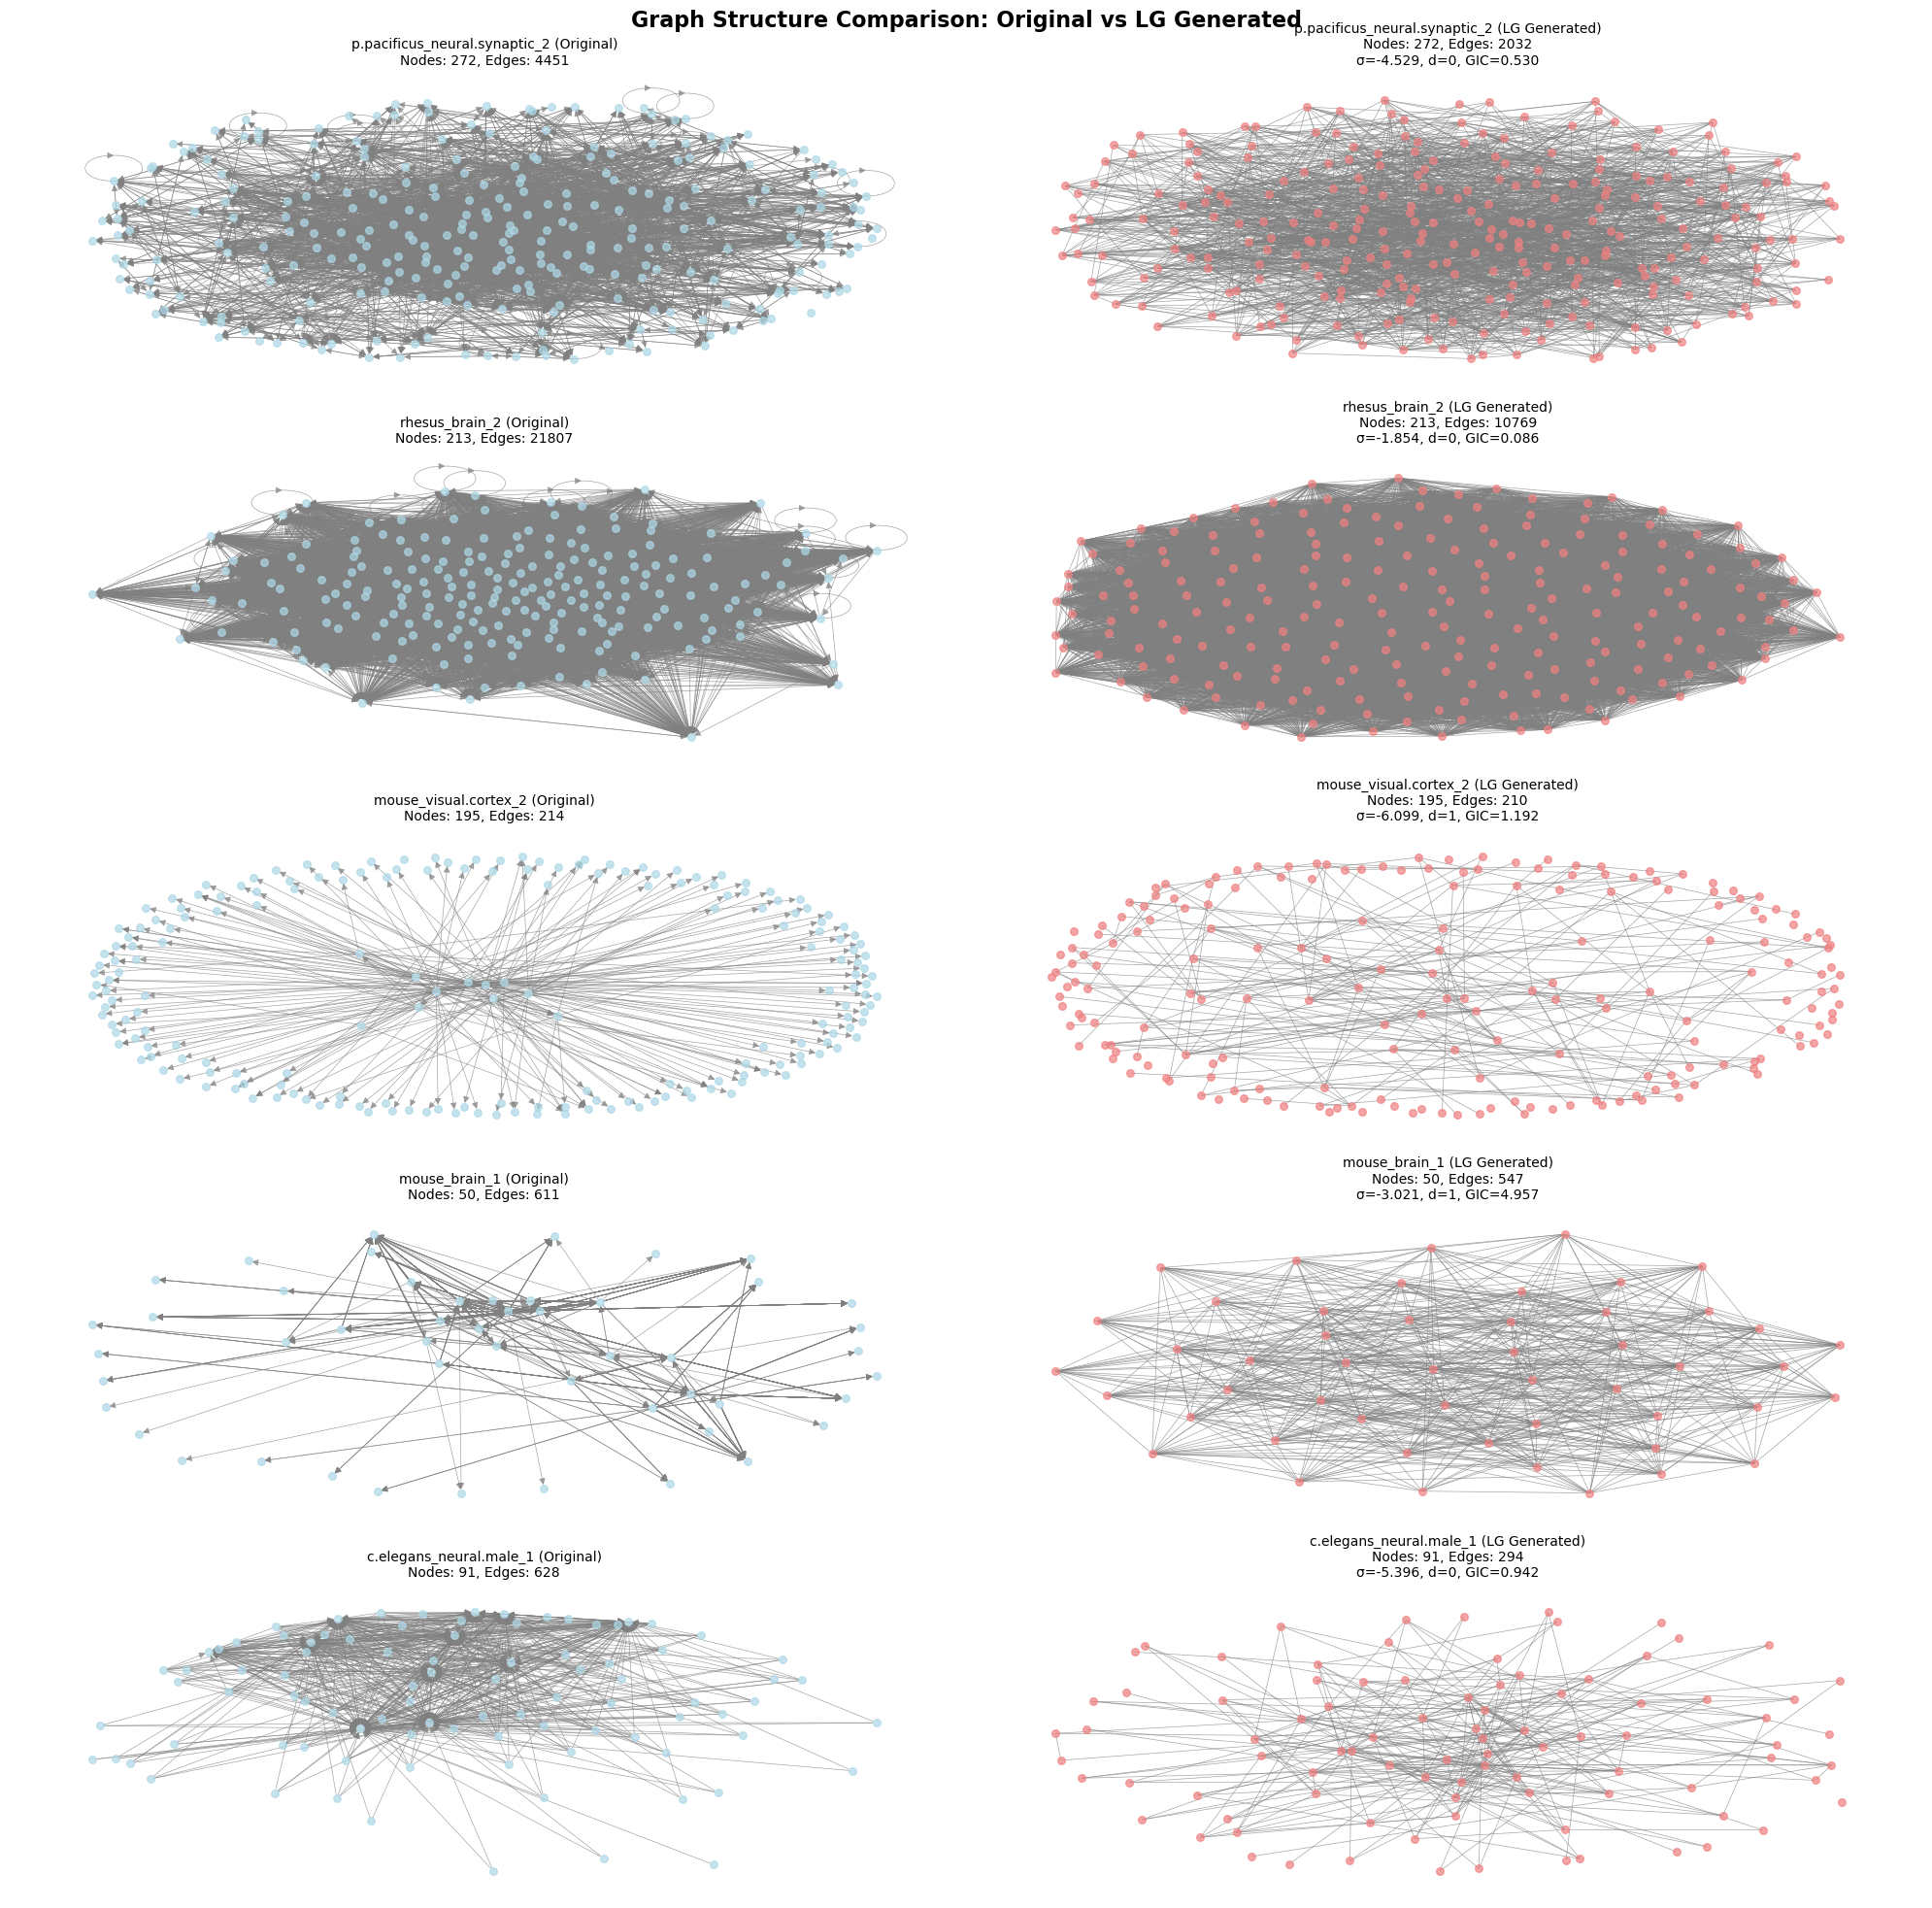

In [15]:
plot_all_graphs_comparison(lg_results, figsize=(20, 20))
 

Creating visualizations for 5 networks...
Network 1: p.pacificus_neural.synaptic_2
  Target σ=-2.9218, Fitted σ=-4.5287, d=0
  GIC: 0.5297, Best iteration: 5383
Network 2: rhesus_brain_2
  Target σ=-5.3957, Fitted σ=-1.8538, d=0
  GIC: 0.0860, Best iteration: 15039
Network 3: mouse_visual.cortex_2
  Target σ=-6.0987, Fitted σ=-6.0987, d=1
  GIC: 1.1924, Best iteration: 3040
Network 4: mouse_brain_1
  Target σ=-1.7556, Fitted σ=-3.0211, d=1
  GIC: 4.9567, Best iteration: 815
Network 5: c.elegans_neural.male_1
  Target σ=-4.5287, Fitted σ=-5.3957, d=0
  GIC: 0.9419, Best iteration: 4244

------------------------------------------------------------
2. All Degree Distribution Comparisons


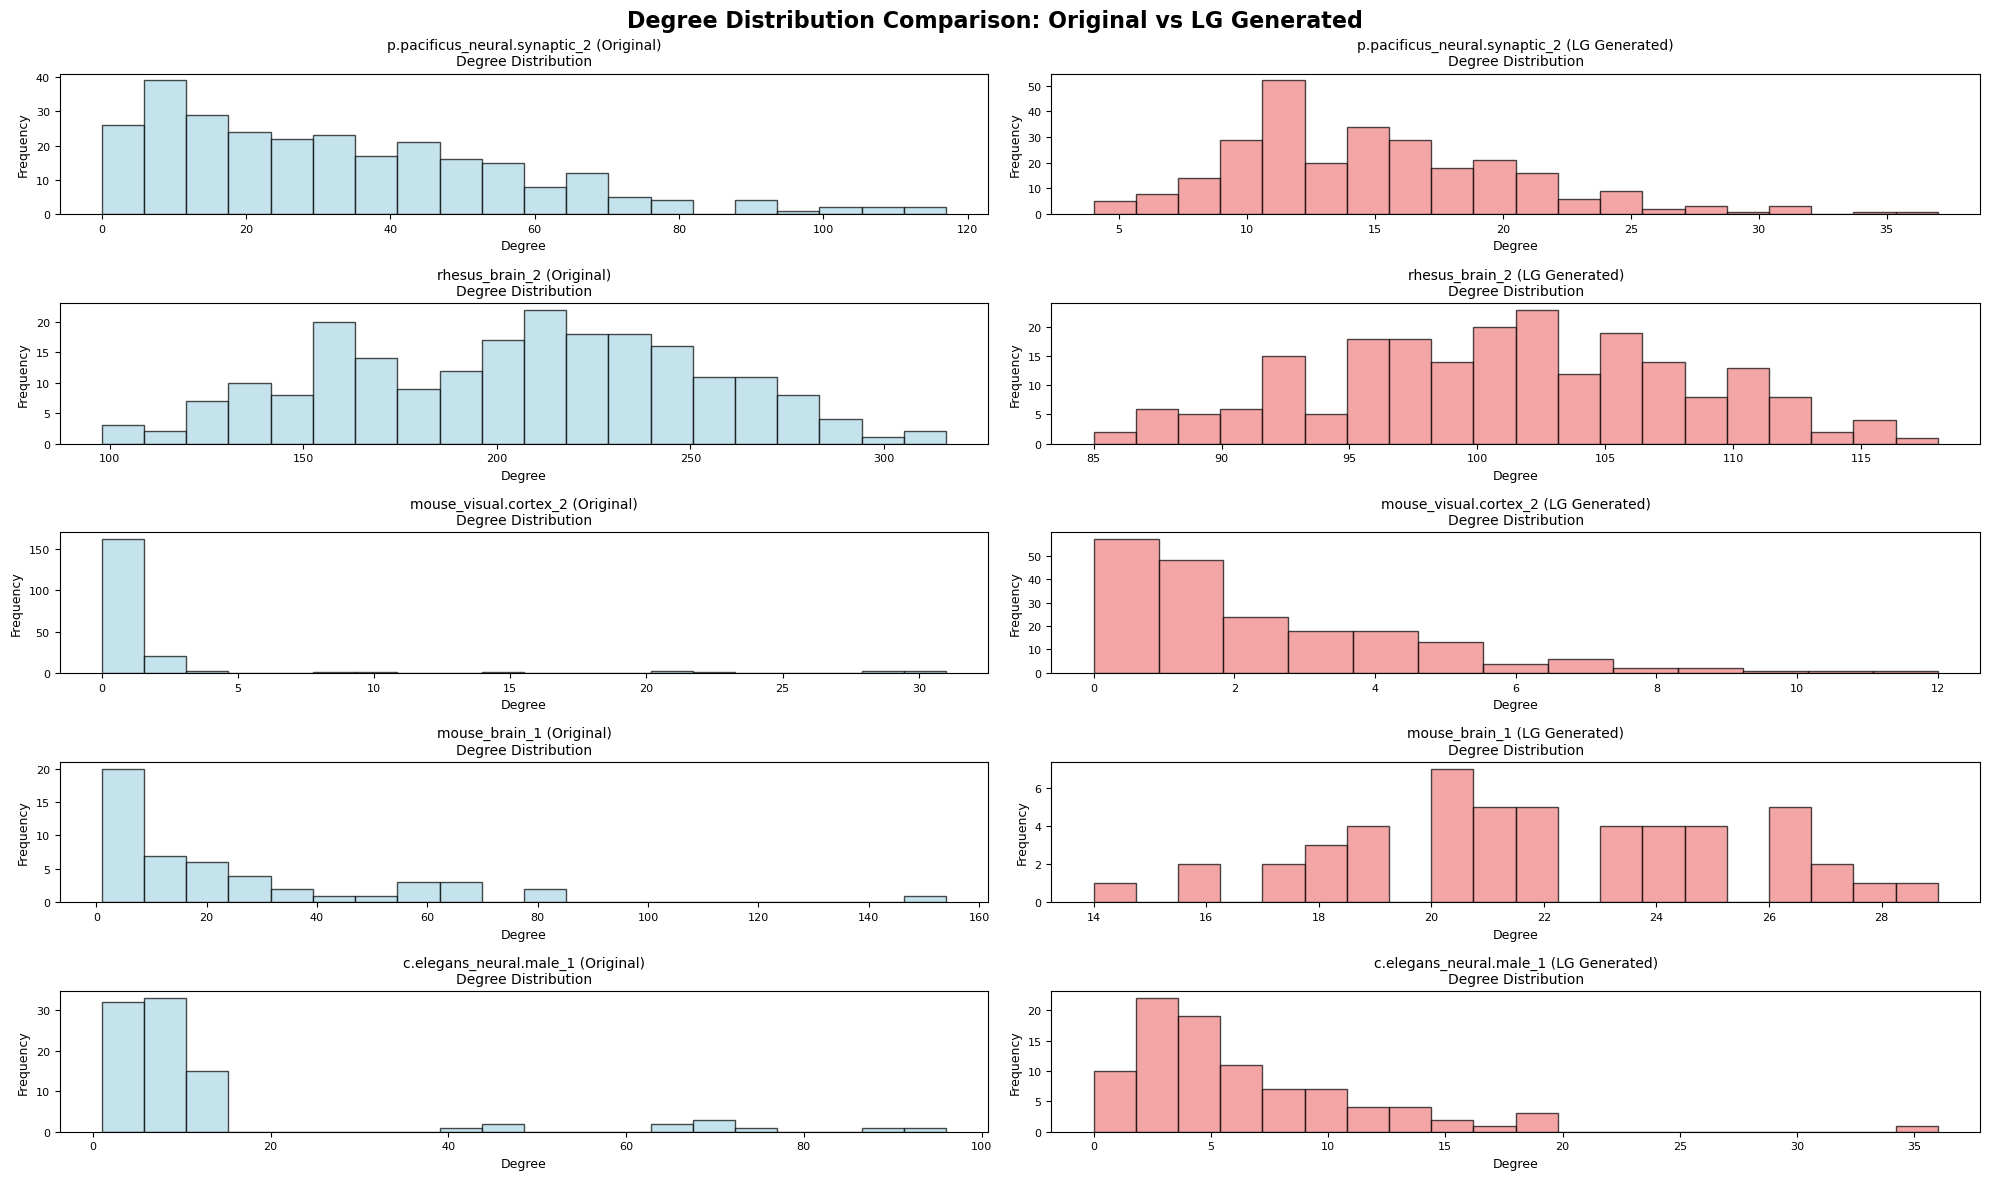


------------------------------------------------------------
3. Overall Metrics Comparison


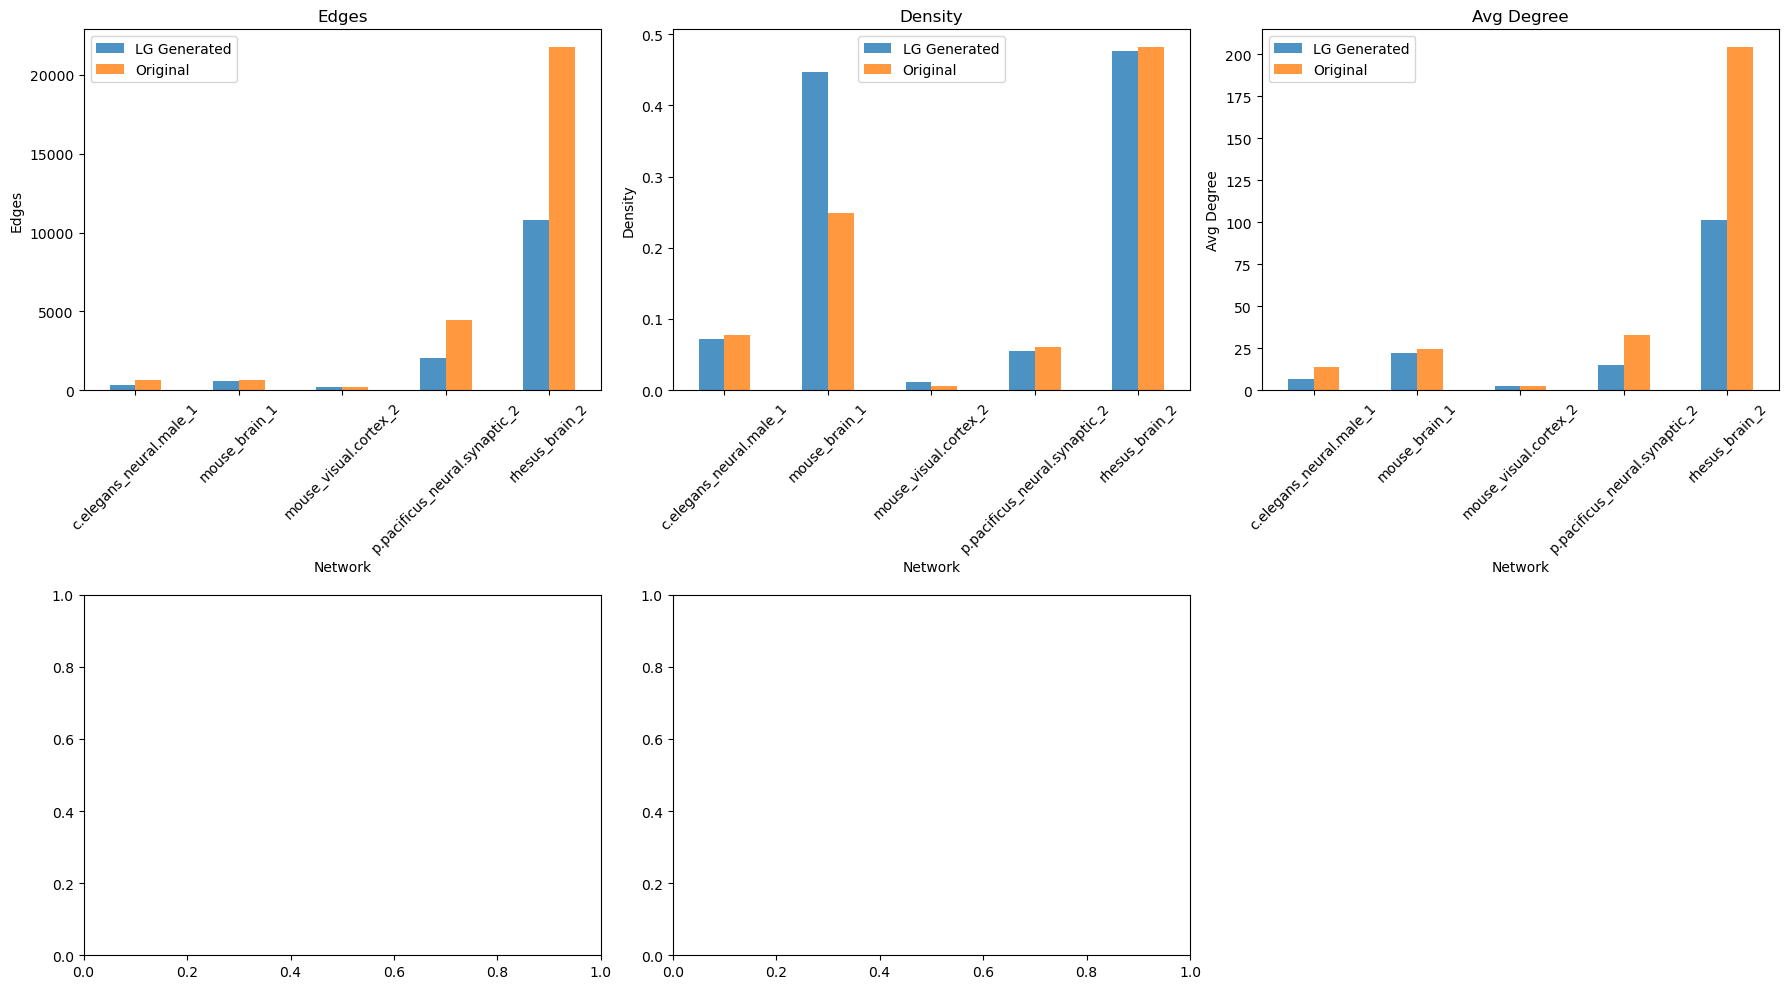


------------------------------------------------------------
4. Summary Table:


,Network,Matched_Name,Original_Nodes,Original_Edges,LG_Edges,Edge_Diff,Target_Sigma,Fitted_Sigma,Target_d,GIC,Best_Iteration
0,p.pacificus_neural.synaptic_2,p.pacificus_neural.synaptic_2,272,4451,2032,2419,-2.921838,-4.528701,0,0.529710,5383
1,rhesus_brain_2,rhesus_brain_2,213,21807,10769,11038,-5.395738,-1.853848,0,0.085982,15039
2,mouse_visual.cortex_2,mouse_visual.cortex_2,195,214,210,4,-6.098704,-6.098704,1,1.192439,3040
3,mouse_brain_1,mouse_brain_1,50,611,547,64,-1.755647,-3.021145,1,4.956743,815
4,c.elegans_neural.male_1,c.elegans_neural.male_1,91,628,294,334,-4.528701,-5.395738,0,0.941888,4244


In [16]:
# Create comprehensive visualizations
def create_comprehensive_comparison(lg_results):
    """
    Create comprehensive comparison visualizations
    """
    print(f"Creating visualizations for {len(lg_results)} networks...")
    
    # Print summary information
    for i, result in enumerate(lg_results):
        network_name = result['network_file'].replace('.graphml', '')
        print(f"Network {i+1}: {network_name}")
        print(f"  Target σ={result['target_sigma']:.4f}, Fitted σ={result['fitted_sigma']:.4f}, d={result['target_d']}")
        print(f"  GIC: {result['gic_value']:.4f}, Best iteration: {result['best_iteration']}")
    
    print(f"\n{'-'*60}")
    print("2. All Degree Distribution Comparisons")
    
    # 2. All degree distribution comparisons in one plot
    plot_all_degree_distributions_comparison(lg_results)
    
    # 3. Overall metrics comparison
    print(f"\n{'-'*60}")
    print("3. Overall Metrics Comparison")
    df_metrics = plot_graph_metrics_comparison(lg_results)
    
    # 4. Summary table
    print(f"\n{'-'*60}")
    print("4. Summary Table:")
    summary_data = []
    for result in lg_results:
        orig_graph = result['original_graph']
        fitted_graph = result['fitted_graph']
        
        summary_data.append({
            'Network': result['network_file'].replace('.graphml', ''),
            'Matched_Name': result['matched_name'],
            'Original_Nodes': orig_graph.number_of_nodes(),
            'Original_Edges': orig_graph.number_of_edges(),
            'LG_Edges': fitted_graph.number_of_edges(),
            'Edge_Diff': abs(orig_graph.number_of_edges() - fitted_graph.number_of_edges()),
            'Target_Sigma': result['target_sigma'],
            'Fitted_Sigma': result['fitted_sigma'],
            'Target_d': result['target_d'],
            'GIC': result['gic_value'],
            'Best_Iteration': result['best_iteration']
        })
    
    df_summary = pd.DataFrame(summary_data)
    display(df_summary)
    
    return df_metrics, df_summary

# Run the comprehensive comparison (this will be executed after lg_results is generated)
if 'lg_results' in locals() and len(lg_results) > 0:
    df_metrics, df_summary = create_comprehensive_comparison(lg_results)
else:
    print("lg_results not found or empty. Run the previous cell first to generate LG graphs.")


### Check the LG Estimation

Here we analyze the logistic regression scatterplots to check for outliers and verify that the estimation is correct. We examine the relationship between features (sum of degrees) and edge probabilities for the selected networks.


In [9]:
def get_logit_params_fit(df_results, connectome_name):
   # load the graph
   real_graph = nx.read_graphml(f'{PATH}{connectome_name}.graphml')
   real_graph = nx.to_numpy_array(real_graph)

   # extract the d value from the df_results
   d = df_results[df_results['network'] == connectome_name]['adjusted_hops'].values[0]

   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()

   # Using default L1 regularization as before, adjust if needed
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   return features, labels


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_57185/852620507.py:82: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(arr[:, col_idx]), bins=50, kde=False, ax=axes[net_idx, col_idx], color='skyblue', alpha=0.6)
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_57185/852620507.py:89: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(arr_no[:, col_idx]), bins=50, kde=False, ax=axes[net_idx, col_idx + num_columns], color='red', alpha=0.6)
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_57185/852620507.py:82: Ru

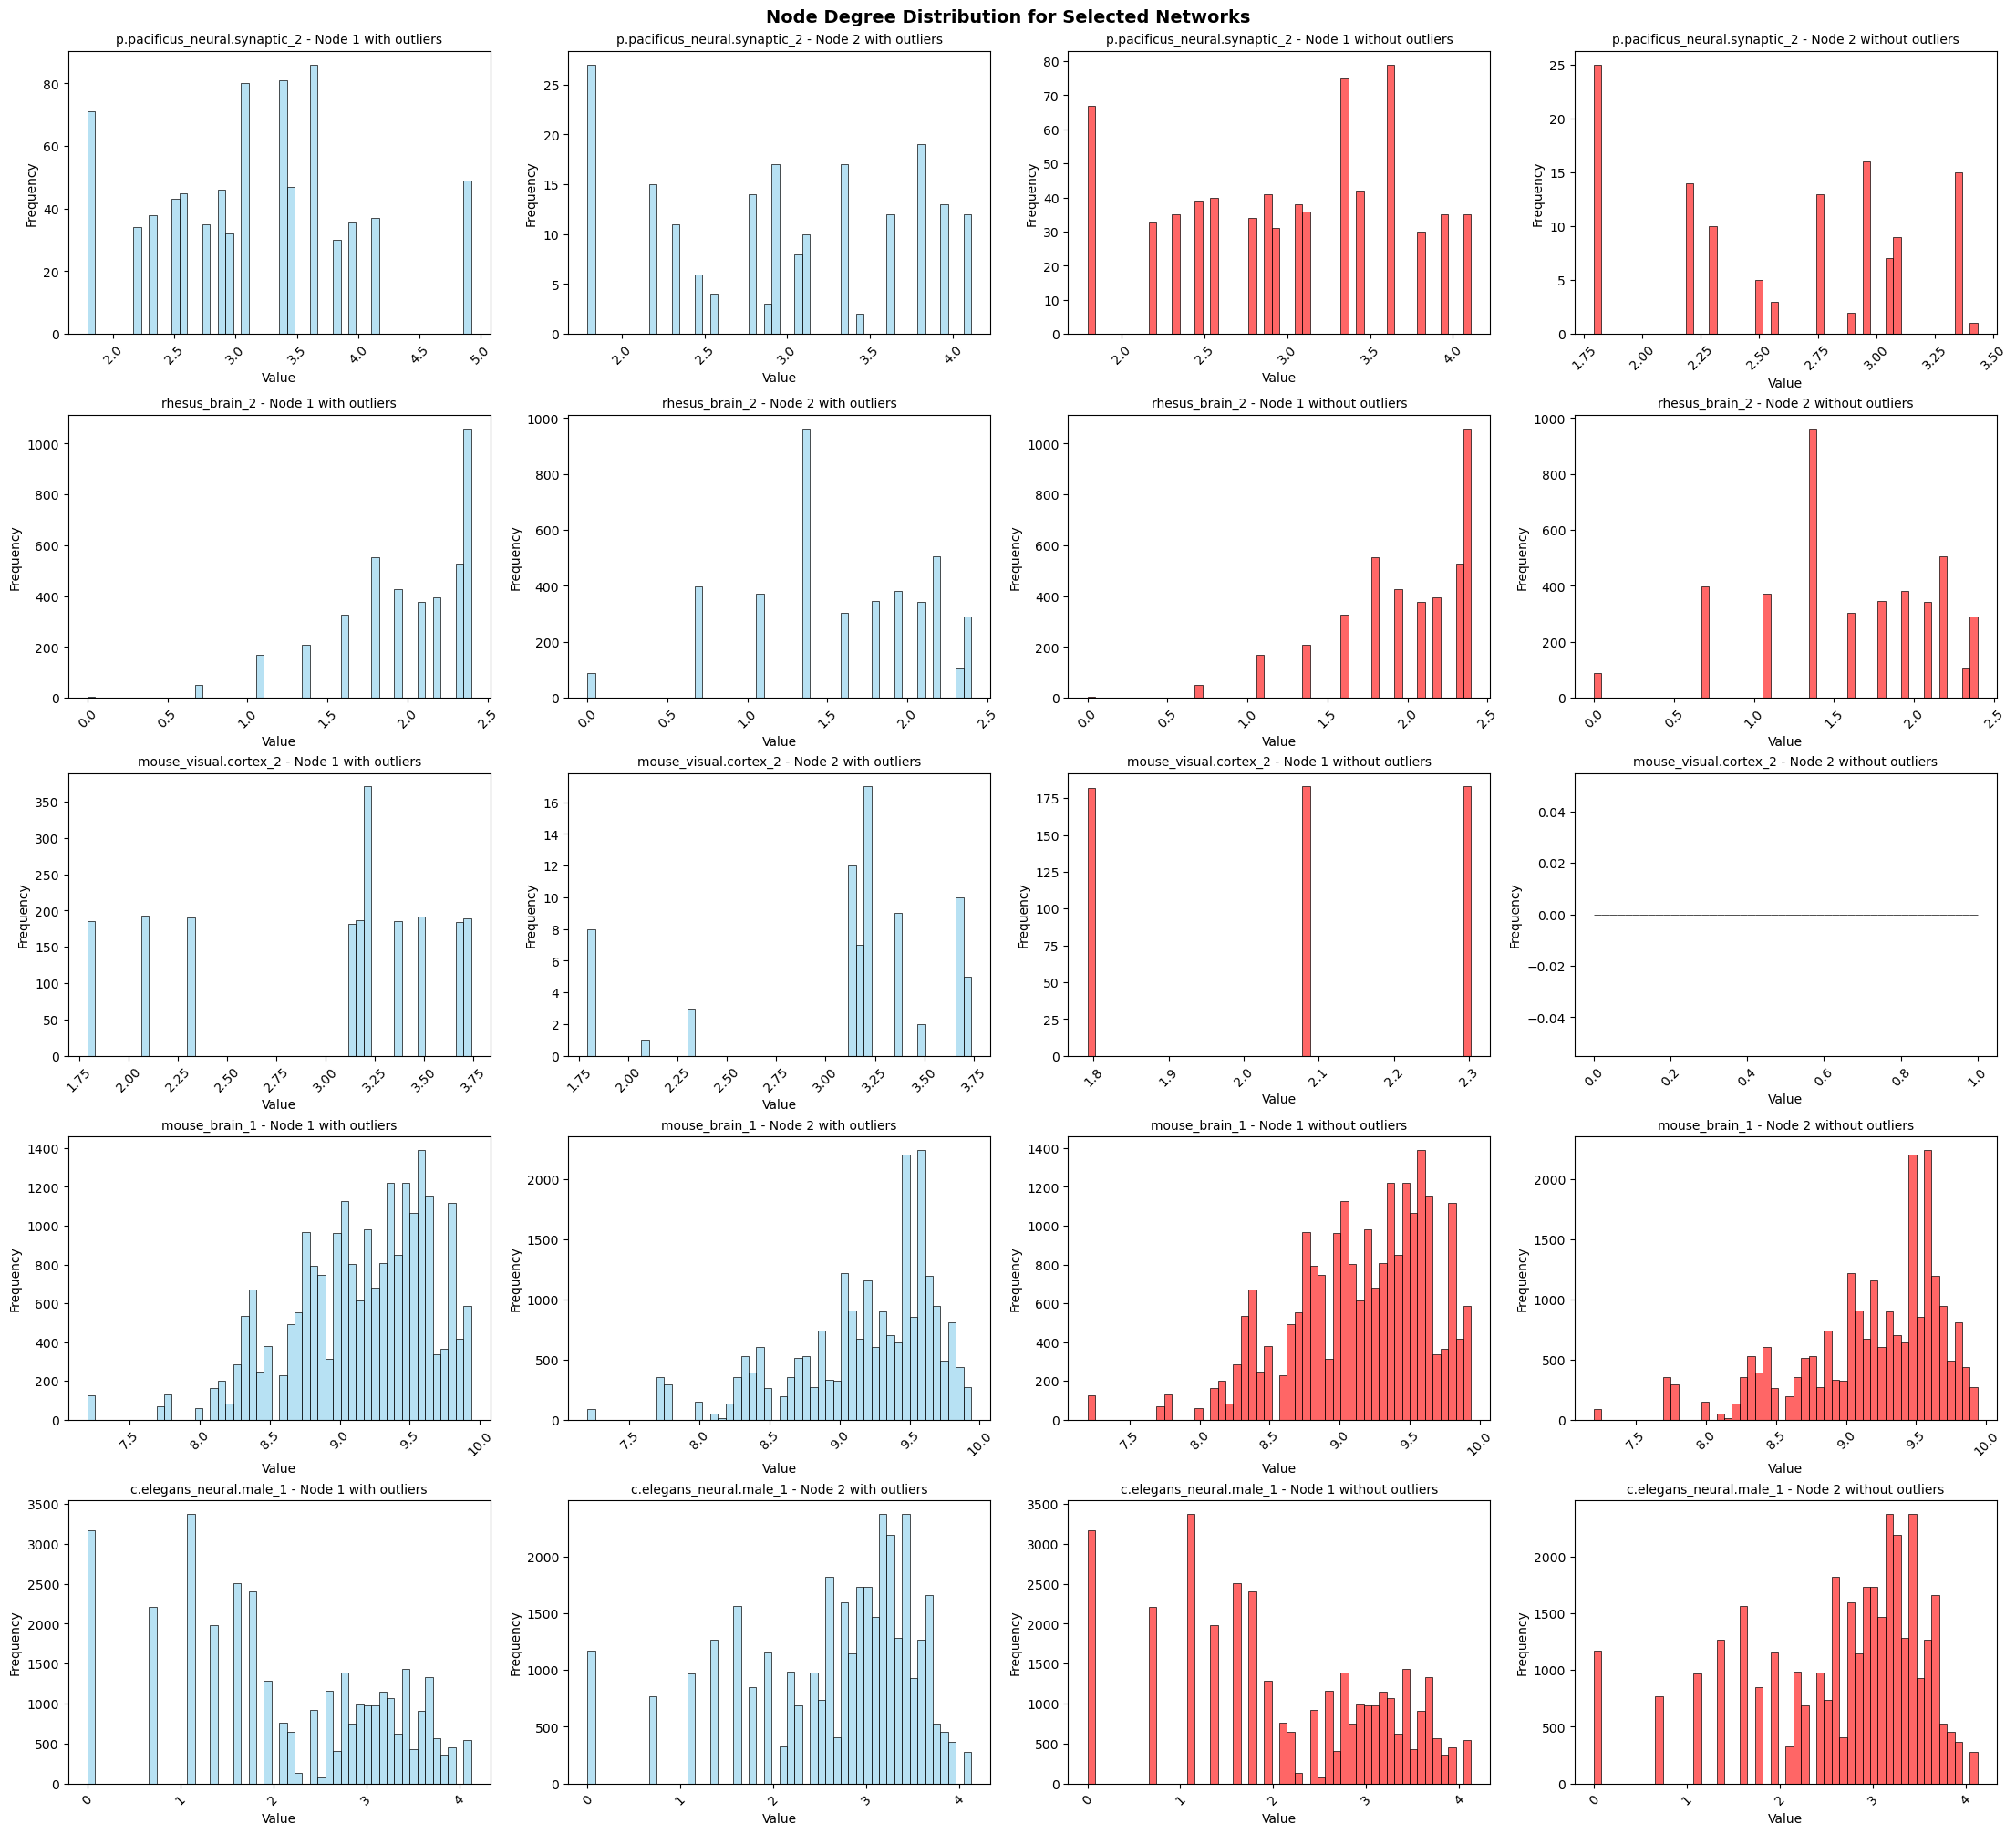

In [35]:
PATH = f'../data/connectomes/'

result_features = {}
result_features_no_outliers = {}
result_labels  = {}
result_labels_no_outliers = {}

def remove_outlier_rows(data, factor=1.5):
    # Calculate Q1, Q3, and IQR for each column
    Q1 = np.percentile(data, 10, axis=0)
    Q3 = np.percentile(data, 90, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - (factor * IQR)
    upper_bound = Q3 + (factor * IQR)
    
    # Create a mask for rows without outliers
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask], mask

def cap_outliers(data, factor=1.5):
    """
    Replaces outlier values with the upper or lower bounds (capping).
    """
    data_capped = data.copy()
    for i in range(data.shape[1]):
        # Calculate Q1, Q3, and IQR for the current column
        Q1 = np.percentile(data[:, i], 25)
        Q3 = np.percentile(data[:, i], 75)
        IQR = Q3 - Q1

        # If IQR is 0, this column likely has many identical values (e.g., zeros).
        # We skip it to avoid incorrectly modifying non-outlier values.
        if IQR == 0:
            continue

        lower_bound = Q1 - (factor * IQR)
        upper_bound = Q3 + (factor * IQR)

        # Cap the values in the column to the calculated bounds
        data_capped[:, i] = np.clip(data[:, i], lower_bound, upper_bound)
        
    return data_capped


######################
######################
######################

for name in selected_networks:
    name = name.replace('.graphml', '')
    features, labels = get_logit_params_fit(df_results, name)
    features, labels = np.array(features), np.array(labels)

    result_features[name] = features
    result_labels[name] = labels

    features_no_outliers, mask = remove_outlier_rows(features, factor=1)
    result_features_no_outliers[name] = features_no_outliers
    result_labels_no_outliers[name] = labels[mask]

    # features_capped = cap_outliers(features, factor=5000000)
    # result_features_no_outliers[name] = features_capped
    # result_labels_no_outliers[name] = labels




#### Plot 

# with and without outliers
num_networks = len(selected_networks)
num_columns = result_features[selected_networks[0].replace('.graphml', '')].shape[1] - 1  # Exclude the first column

# Adjust the number of columns to 4 for with and without outliers
fig, axes = plt.subplots(nrows=num_networks, ncols=4, figsize=(22, 4 * num_networks), constrained_layout=True)
for net_idx, network in enumerate(selected_networks):
    network_name = network.replace('.graphml', '')
    arr = result_features[network_name][:, 1:]
    arr_no = result_features_no_outliers[network_name][:, 1:]
    for col_idx in range(num_columns):
        # Plot with outliers
        sns.histplot(np.log(arr[:, col_idx]), bins=50, kde=False, ax=axes[net_idx, col_idx], color='skyblue', alpha=0.6)
        axes[net_idx, col_idx].set_title(f'{network_name} - Node {col_idx+1} with outliers', fontsize=10)
        axes[net_idx, col_idx].set_xlabel('Value', fontsize=10)
        axes[net_idx, col_idx].set_ylabel('Frequency', fontsize=10)
        axes[net_idx, col_idx].tick_params(axis='x', rotation=45)

        # Plot without outliers
        sns.histplot(np.log(arr_no[:, col_idx]), bins=50, kde=False, ax=axes[net_idx, col_idx + num_columns], color='red', alpha=0.6)
        axes[net_idx, col_idx + num_columns].set_title(f'{network_name} - Node {col_idx+1} without outliers', fontsize=10)
        axes[net_idx, col_idx + num_columns].set_xlabel('Value', fontsize=10)
        axes[net_idx, col_idx + num_columns].set_ylabel('Frequency', fontsize=10)
        axes[net_idx, col_idx + num_columns].tick_params(axis='x', rotation=45)

plt.suptitle('Node Degree Distribution for Selected Networks', fontsize=14, fontweight='bold')
plt.show()


In [36]:
def get_sigmas_features_labels(data, labels, df_results, networks):
    df_results2 = df_results.copy()
    for name in networks:
        name = name.replace('.graphml', '')
        print(name)

        # extract the d value from the df_results
        d = df_results2[df_results2['network'] == network_name]['adjusted_hops'].values[0]

        # Estimation, with dummy erdos-renyi graph
        est = estimator.LogitRegEstimator(nx.erdos_renyi_graph(n=10, p=0.9), d=d)
        features = data[name]
        # add small noise to the features
        feature = features + np.random.normal(0, 0.001, features.shape)
        label   = labels[name]

        # Using default L1 regularization as before, adjust if needed
        result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=feature, labels=label)
        sigma = params[0]
        print(f"Sigma for {name}: {sigma}")
        print(f"Previous sigma: {df_results2[df_results2['network'] == name]['estimated_sigma'].values[0]}")
        print()
        df_results2.loc[df_results2['network'] == name, 'estimated_sigma_2'] = sigma

    return df_results2


df_results2 = get_sigmas_features_labels(result_features_no_outliers, result_labels_no_outliers, df_results, selected_networks)

p.pacificus_neural.synaptic_2
Sigma for p.pacificus_neural.synaptic_2: -3.595662509495822
Previous sigma: -2.9218377658483172

rhesus_brain_2
Sigma for rhesus_brain_2: -5.395836829821322
Previous sigma: -5.3957384355164475

mouse_visual.cortex_2
Sigma for mouse_visual.cortex_2: -9.411273485047863
Previous sigma: -6.098703884341722

mouse_brain_1
Sigma for mouse_brain_1: -1.7553106157747558
Previous sigma: -1.755646644368074

c.elegans_neural.male_1
Sigma for c.elegans_neural.male_1: -4.528546642775594
Previous sigma: -4.528701094583439



/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


In [37]:
df_results2[['network', 'adjusted_hops', 'estimated_sigma', 'estimated_sigma_without_outliers']].loc[df_results2['network'].isin([name.replace('.graphml', '') for name in selected_networks])]

,network,adjusted_hops,estimated_sigma,estimated_sigma_2
0,rhesus_brain_2,0,-5.395738,-5.395837
6,p.pacificus_neural.synaptic_2,0,-2.921838,-3.595663
7,mouse_brain_1,1,-1.755647,-1.755311
9,mouse_visual.cortex_2,1,-6.098704,-9.411273
15,c.elegans_neural.male_1,0,-4.528701,-4.528547
